In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [3]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))

In [4]:
# features = data[0]

# mobius = generate_mobius(features, 2)
# mobius.pop(0)
# print(len(mobius))
# capacity = mobius_to_capacity(mobius, features)

# print("Möbius:")
# for i in range(len(mobius)):
#     print(f"Mobius of {mobius[i].X} is {mobius[i].mu:.3f}")

# print("\nDerived Capacity:")
# for c in capacity:
#     print(f"Capacity of {c.X} is {c.mu:.3f}")


In [5]:
# mutated_mobius = mutate(mobius, mutation_rate=0.2)
# print("\nMutated Möbius:")
# for i in range(len(mutated_mobius)):
#     print(f"Mobius of {mutated_mobius[i].X} is {mutated_mobius[i].mu:.3f}")

In [32]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 15

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.2)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[i], lst_mobius[j])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 135
Test Möbius measures completed!
Total number of capacities: 135


In [23]:
mobius = generate_mobius(features, 2)
print("Möbius:")
for i in range(len(mobius)):
    print(f"Mobius of {mobius[i].X} is {mobius[i].mu:.3f}")

capacity = capacities_list[0]
print("\nDerived Capacity:")
for c in capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.078
Mobius of [1] is 0.194
Mobius of [2] is 0.453
Mobius of [3] is 0.019
Mobius of [0, 1] is 0.543
Mobius of [0, 2] is 0.740
Mobius of [0, 3] is 0.272
Mobius of [1, 2] is 0.739
Mobius of [1, 3] is 0.546
Mobius of [2, 3] is 0.317

Derived Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.093
Capacity of [1] is 0.057
Capacity of [2] is 0.097
Capacity of [3] is 0.118
Capacity of [0, 1] is 0.223
Capacity of [0, 2] is 0.349
Capacity of [0, 3] is 0.339
Capacity of [1, 2] is 0.235
Capacity of [1, 3] is 0.298
Capacity of [2, 3] is 0.289
Capacity of [0, 1, 2] is 0.559
Capacity of [0, 1, 3] is 0.591
Capacity of [0, 2, 3] is 0.667
Capacity of [1, 2, 3] is 0.548
Capacity of [0, 1, 2, 3] is 1.000


In [24]:
import copy

In [25]:
# Fuzzy verion
def FuzzLOO(DS, mu, sim = S1, choquet_version='d_choquet', p=1, q=1, time_counter=False):
    """ Classifieur * tuple[array, array] -> float
    """
    ###################### A COMPLETER 
    pt = 0
    Xm, Ym = DS

    input_dimension= Xm[0].shape[0]

    C = KNNFuzz(input_dimension = input_dimension, mu=mu, sim=sim, choquet_version=choquet_version, p=p, q=q)

    if time_counter:
        tic = time.time()
    for i in range(len(Xm)):
        Xtest, Ytest = Xm[i], Ym[i]
        
        Xapp, Yapp = np.array(list(Xm[:i])+list(Xm[i+1:])), np.array(list(Ym[:i])+list(Ym[i+1:]))

        cl = copy.deepcopy(C)
        cl.train(desc_set=Xapp, label_set=Yapp)

        if cl.accuracy([Xtest], [Ytest]) == 1: pt += 1

    if time_counter:
        toc = time.time()
        print(f'Result in {(toc-tic):0.4f} seconds.')
    
    return pt/len(Xm)

In [26]:
FuzzLOO(
    DS=(data, labels),
    mu=capacities_list[0],
)

0.6666666666666666

In [27]:
def fitness_function(capacities_list: np.ndarray, DS: Tuple[np.ndarray, np.ndarray], sim = S1, choquet_version='d_choquet', p=1, q=1, time_counter=False) -> np.ndarray:
    """
    Objective function for optimizing Möbius measures:
    - capacities_list: list of Möbius measures represented as capacities
    - DS: Tuple (X_data, y_data)
    - C: Choquet similarity function (e.g., Choquet_classic)
    
    Returns:
    - 1D array of negative LOO accuracy (to minimize)
    """
    results = []
    i = 0
    for capacity in capacities_list:
        i += 1
        print(f"Processing capacity {i}/{len(capacities_list)}...")
        if not is_monotonic(capacity):
            results.append(float('inf'))  # Penalize non-monotonic capacity
            continue

        acc = FuzzLOO(DS, capacity, sim=sim, choquet_version=choquet_version, p=p, q=q, time_counter=time_counter)

        # negative accuracy for minimization
        results.append(-acc)

    return np.array(results)


In [33]:
FF_res = fitness_function(
    capacities_list=capacities_list,
    DS=(data, labels),
    sim=S1,
    choquet_version='d_choquet',
    p=1,
    q=1,
    time_counter=False
)

Processing capacity 1/135...
Processing capacity 2/135...
Processing capacity 3/135...
Processing capacity 4/135...
Processing capacity 5/135...
Processing capacity 6/135...
Processing capacity 7/135...
Processing capacity 8/135...
Processing capacity 9/135...
Processing capacity 10/135...
Processing capacity 11/135...
Processing capacity 12/135...
Processing capacity 13/135...
Processing capacity 14/135...
Processing capacity 15/135...
Processing capacity 16/135...
Processing capacity 17/135...
Processing capacity 18/135...
Processing capacity 19/135...
Processing capacity 20/135...
Processing capacity 21/135...
Monotonicity check failed between [3] and [0, 1]
X: [3], mu: 0.21175794709392698
Y: [0, 1], mu: 0.1936539895394809

Processing capacity 22/135...
Processing capacity 23/135...
Processing capacity 24/135...
Processing capacity 25/135...
Processing capacity 26/135...
Processing capacity 27/135...
Processing capacity 28/135...
Processing capacity 29/135...
Processing capacity 30/

In [37]:
# Get the best capacity
best_index = np.argmin(FF_res)
best_capacity = capacities_list[best_index]
print(f"Best capacity index: {best_index}, Accuracy: {-FF_res[best_index]:.4f}")

# get best mobius
best_mobius = lst_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in best_mobius]}")

Best capacity index: 0, Accuracy: 0.6667
Best Möbius measure: ['[0]: 0.902', '[1]: 0.290', '[2]: 0.798', '[3]: 0.708', '[0, 1]: 0.615', '[0, 2]: 0.651', '[0, 3]: 0.967', '[1, 2]: 0.423', '[1, 3]: 0.436', '[2, 3]: 0.532']


In [38]:
# get mobius
for i in range(len(capacities_list[best_index])):
    print(capacities_list[best_index][i].X, capacities_list[best_index][i].mu)

[] 0.0
[0] 0.1426469176561466
[1] 0.045823116140751304
[2] 0.1262586574543647
[3] 0.11197523683197443
[0, 1] 0.2857130164691209
[0, 2] 0.3719455755896682
[0, 3] 0.40764615811496857
[1, 2] 0.23893751035510752
[1, 3] 0.22683504433316917
[2, 3] 0.32233055130443966
[0, 1, 2] 0.5818674111626341
[0, 1, 3] 0.6197489482883863
[0, 2, 3] 0.7210414730665907
[1, 2, 3] 0.5040460955656259
[0, 1, 2, 3] 1.0


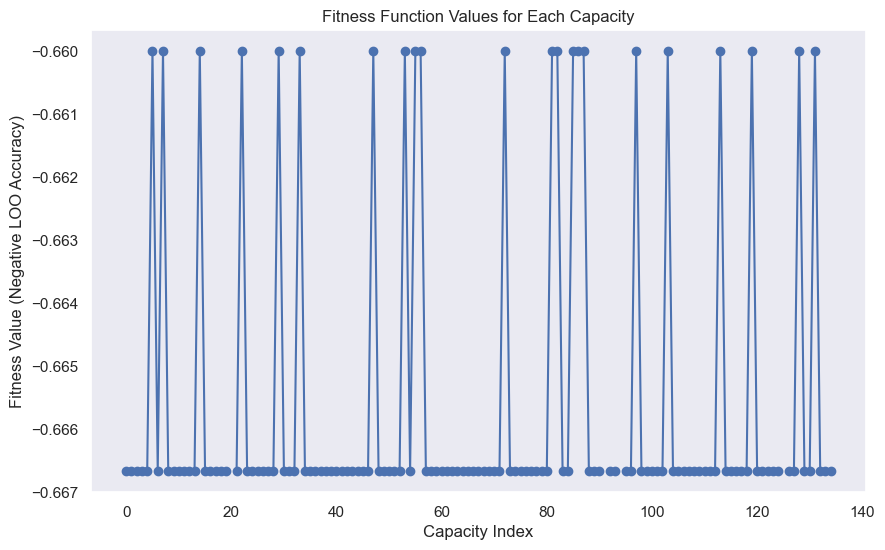

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(capacities_list)), FF_res, marker='o')
plt.title('Fitness Function Values for Each Capacity')
plt.xlabel('Capacity Index')
plt.ylabel('Fitness Value (Negative LOO Accuracy)')
plt.grid()
plt.show()